I have now implemented a first version of the v0.2 idea that instead of estimating $P_b$ we need to estimate $P_{b|a}$.

In [14]:
# put root folder of repo PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

C:\GITHUB\COMMOTIONSFramework


In [19]:
# imports needed to run the simulations
import numpy as np
import commotions
from sc_scenario import CtrlType, get_assumptions_dict, SCSimulation

First running a pedestrian crossing scenario with just the base assumptions, for an initial situation such that this just barely has the car passing first. (Increasing the car's initial X position to 45 m makes the pedestrian slide in front.)

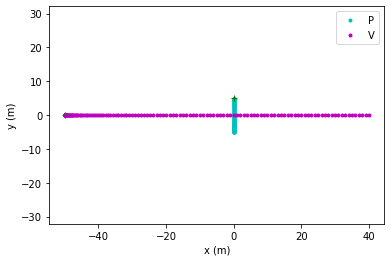

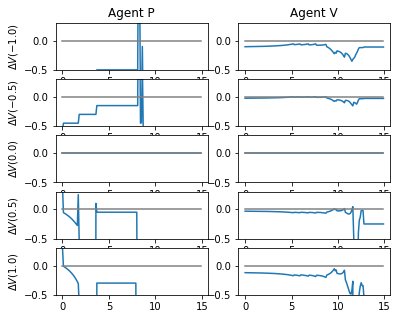

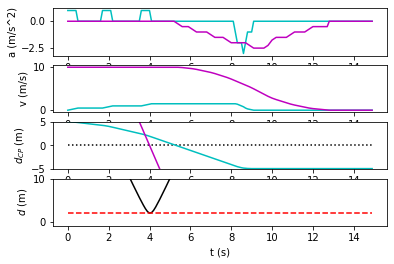

In [50]:
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 10))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

Now turning on value based behaviour estimation (`oBEvs` here). This causes the interaction to break down quite a bit, with lots of oscillations in both agents' behaviour. But we can see in the $P_{b|a}$ plots that the vehicle is estimating the acceleration should increase the probability of the pedestrian yielding - but the vehicle still does not do it.

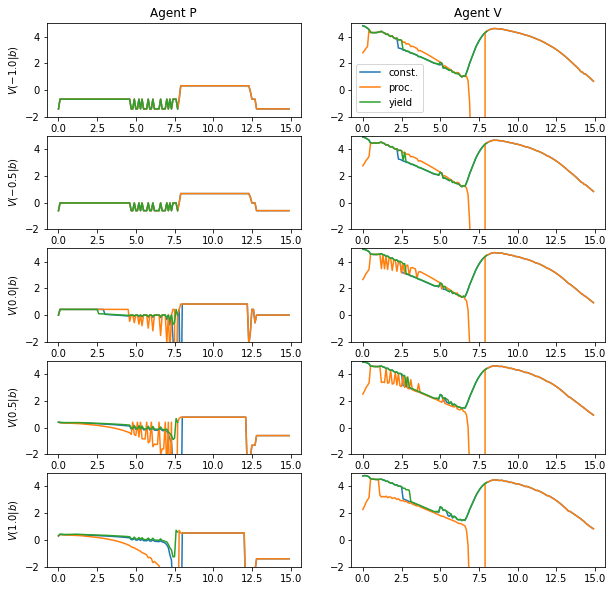

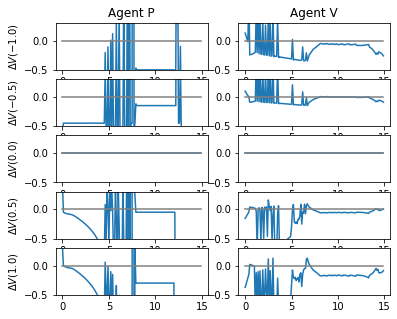

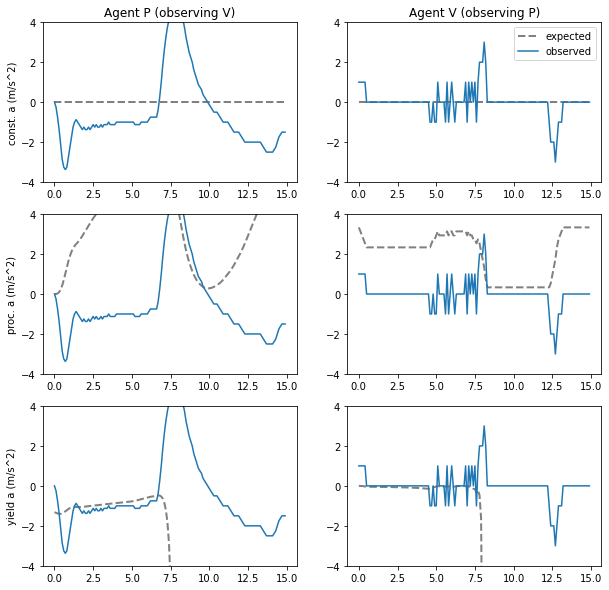

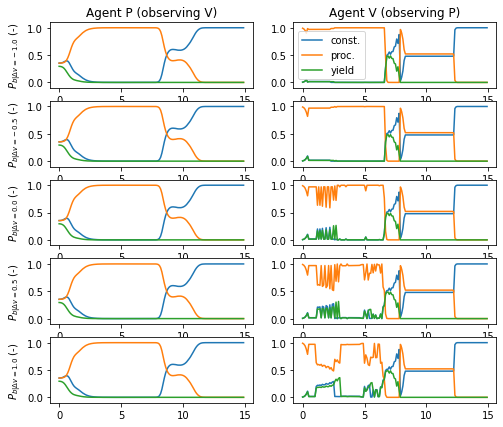

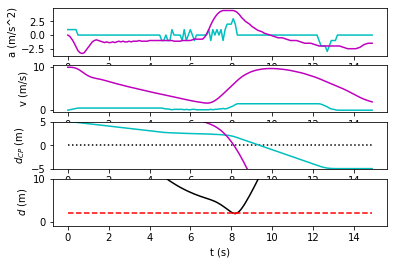

In [52]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Now turning on also evidence accumulation. This stabilises things - but now the vehicle no longer thinks that accelerating could affect the pedestrian's behaviour - I am not sure why.

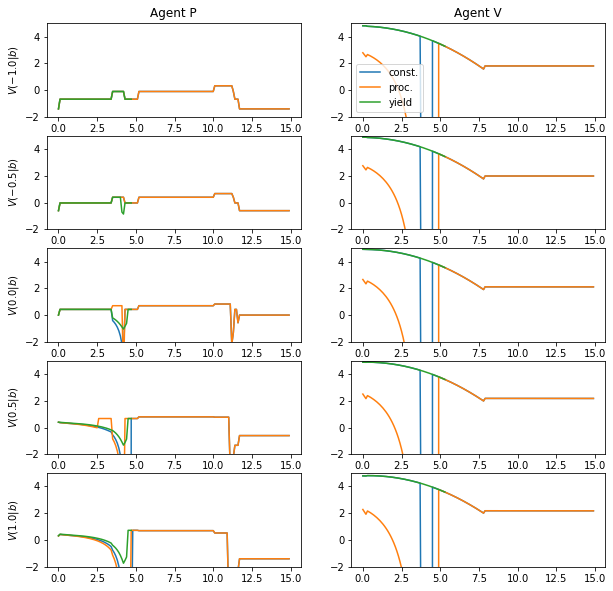

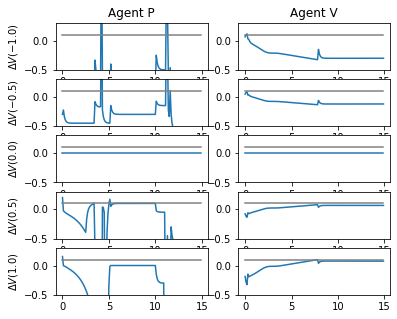

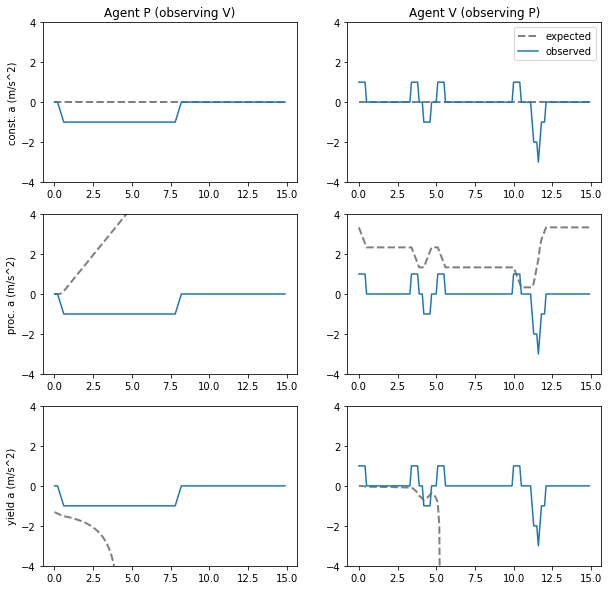

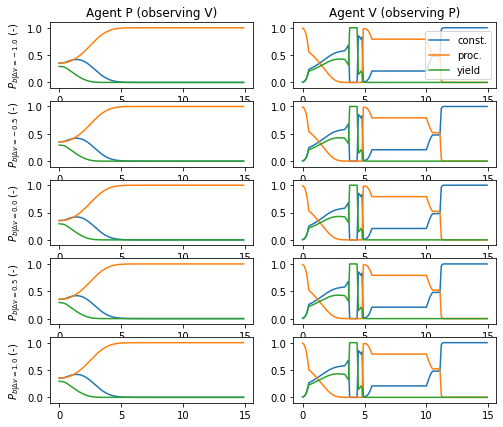

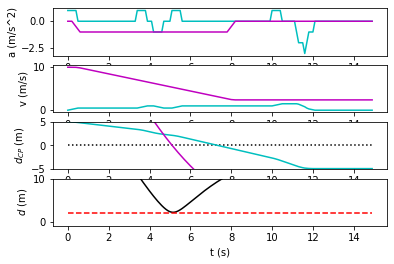

In [53]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Now turning off value based behaviour estimation and evidence accumulation, and instead turning on action observation based behaviour estimation (`oBEao`). Again this causes a lot of oscillation and a poor interaction.

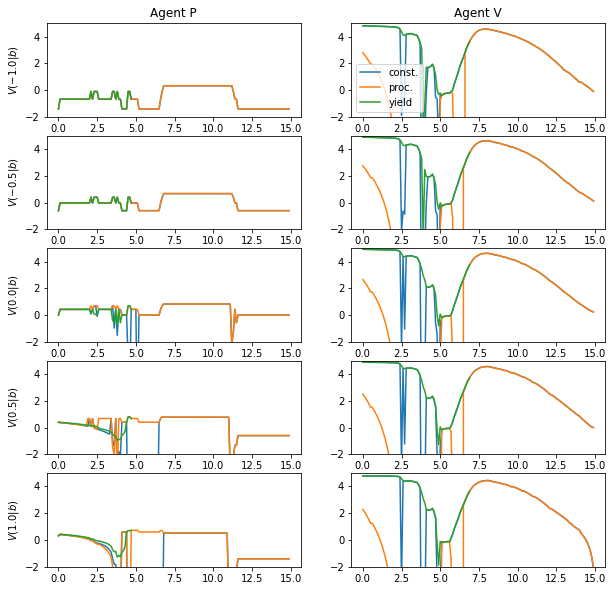

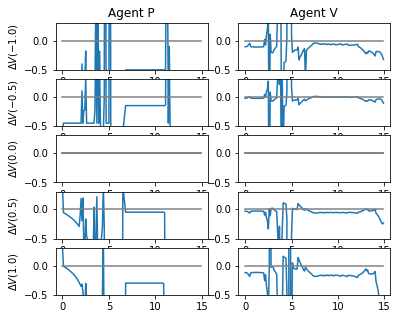

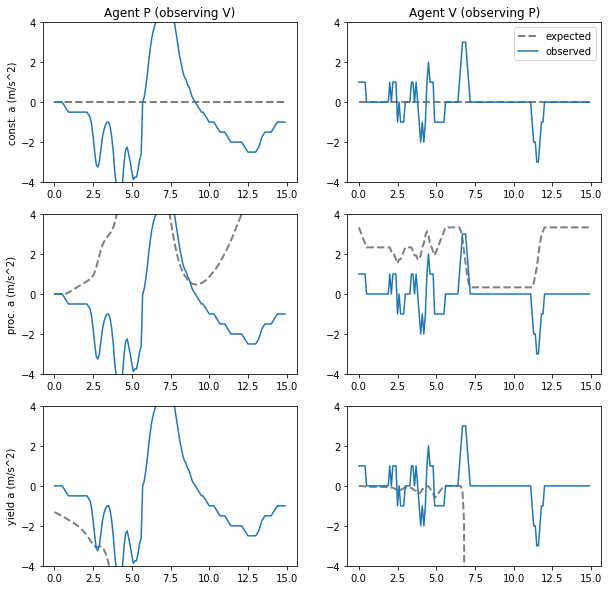

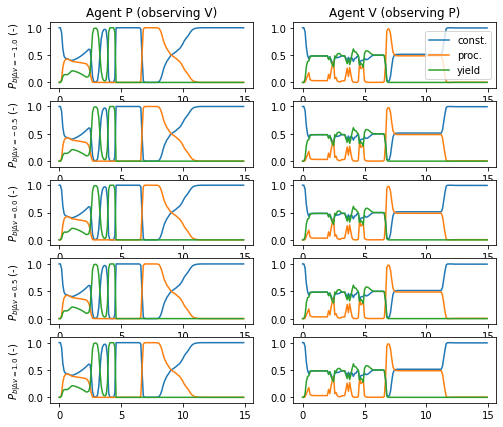

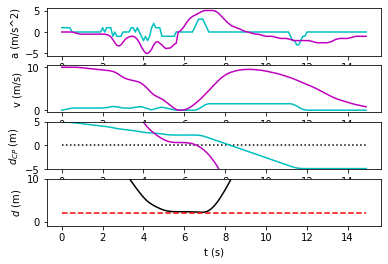

In [54]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Adding evidence accumulation into the mix here dampens things a bit, but not much.

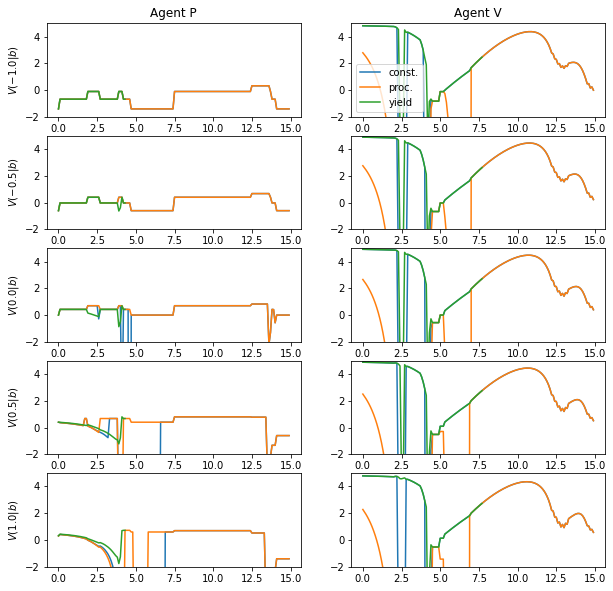

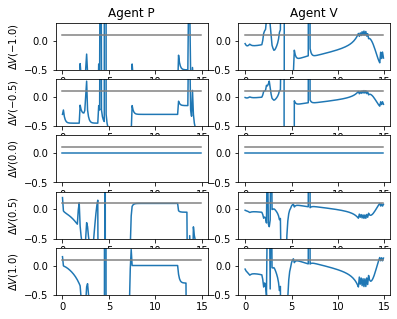

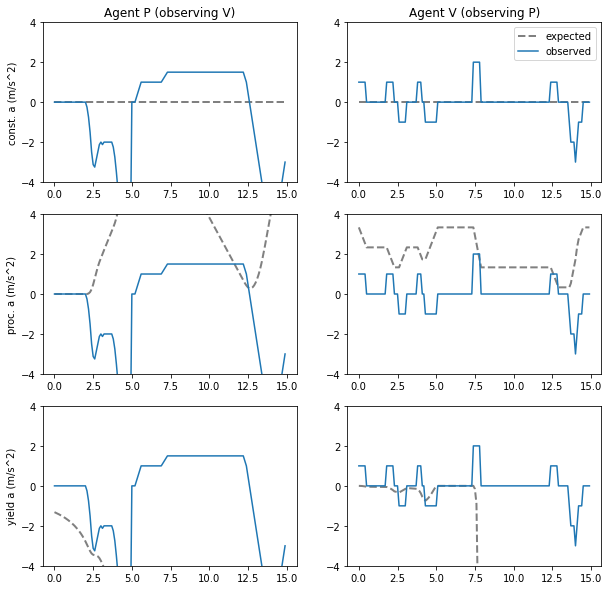

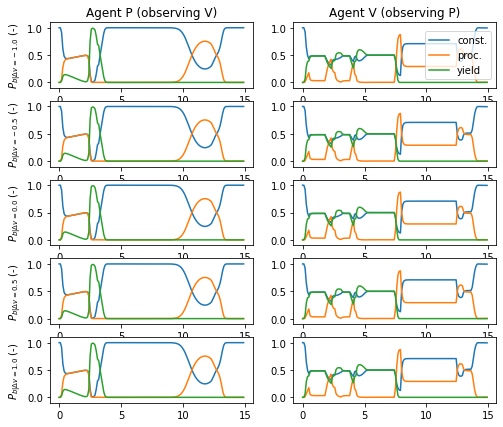

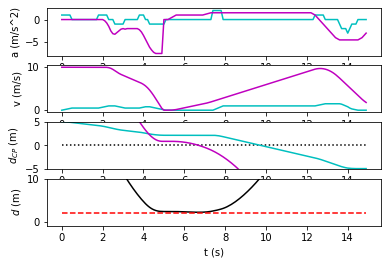

In [55]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = False, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Now, interestingly, turning on both value based and action observation based behaviour estimation improves the interaction quite considerably.

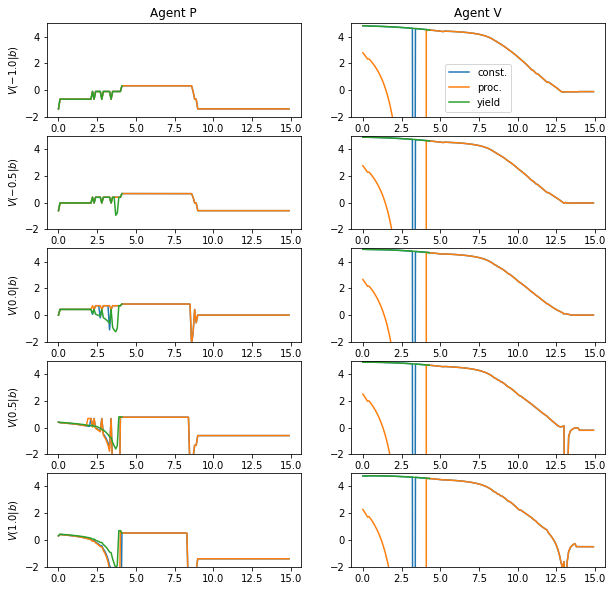

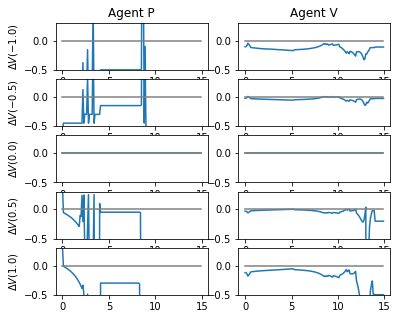

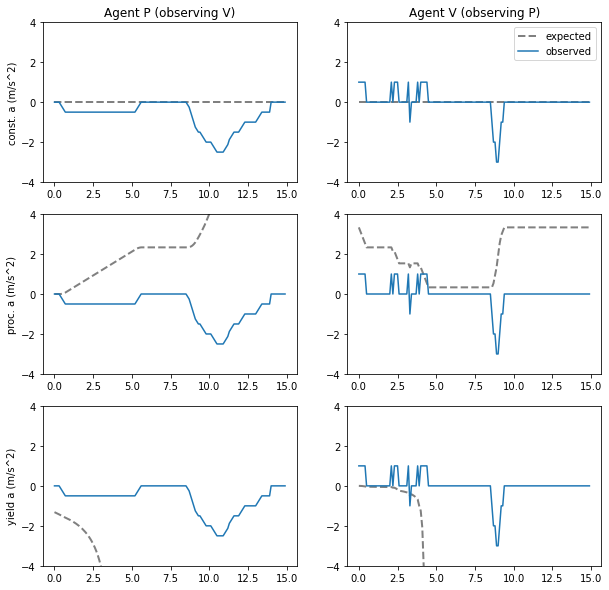

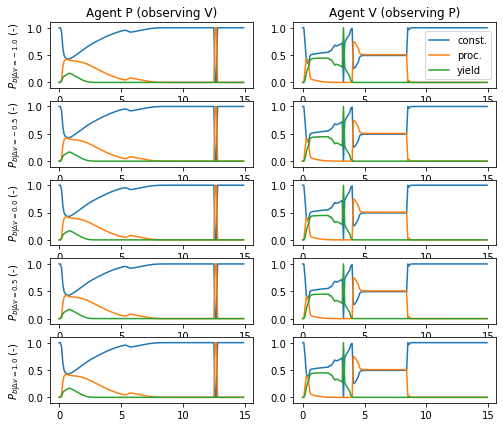

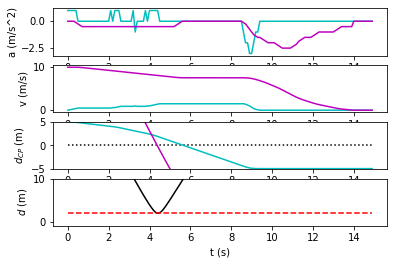

In [59]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

And turning on also evidence accumulation essentially brings us back to the original smooth behaviour of just the base framework.

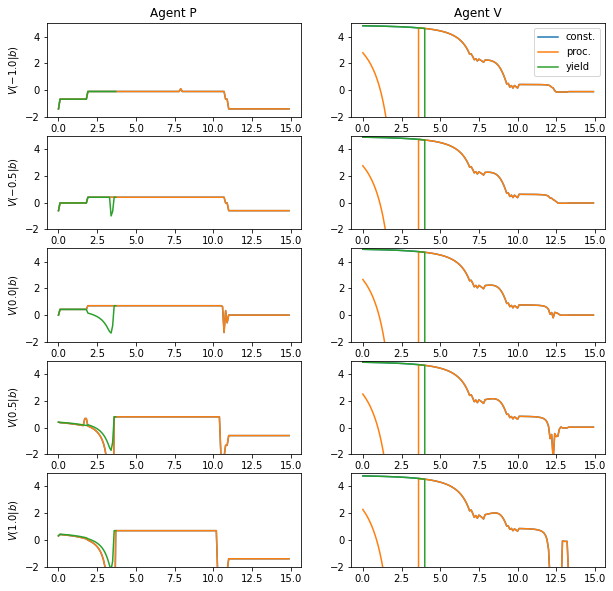

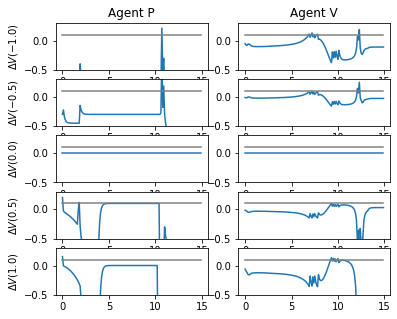

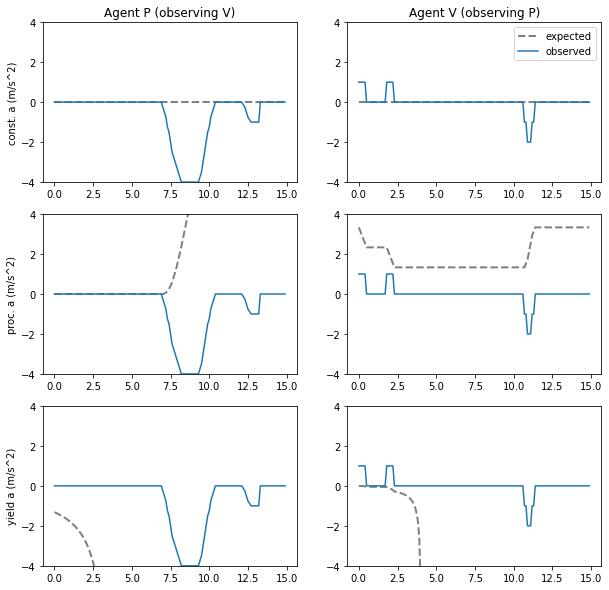

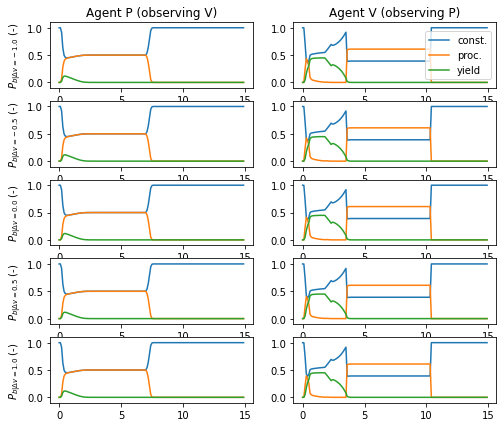

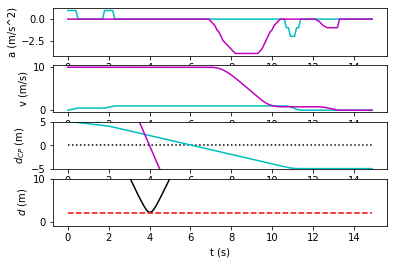

In [60]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = True, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

And really interestingly, now slightly increasing the initial TTA of the vehicle, causes a situation where the vehicle performs what looks like a rather smooth and nice yielding to the pedestrian - from being a bit uncertain about what the pedestrian is up to. And it takes the pedestrian a few seconds to decide that it looks safe to cross in front of the vehicle- It's a quite natural-looking interaction I think.

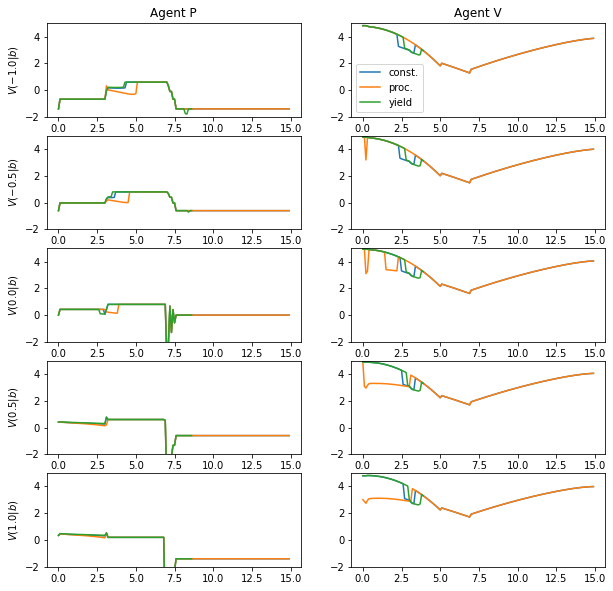

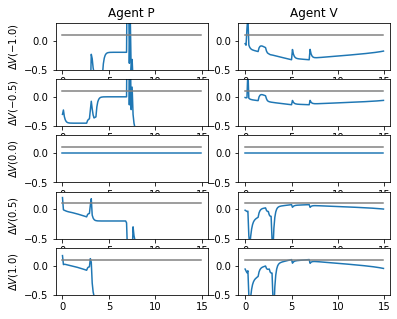

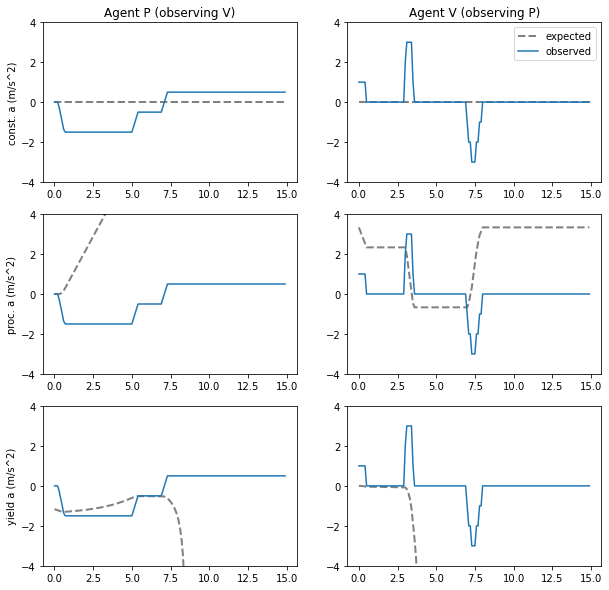

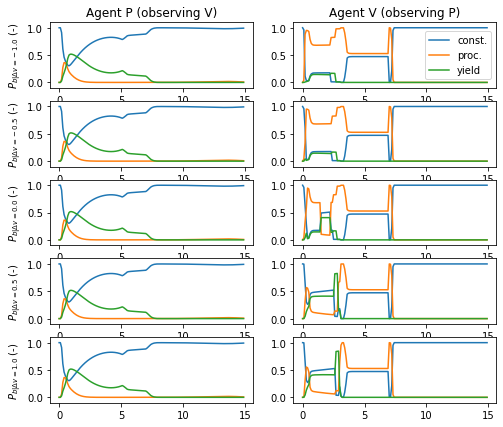

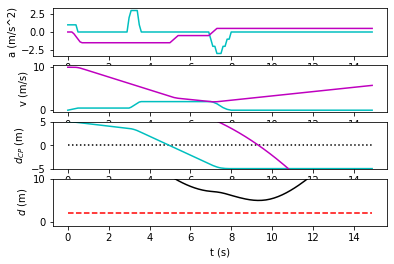

In [62]:
INITIAL_POSITIONS = np.array([[0,-5], [45, 0]])
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Some overall thoughts here:

* I have not at all tuned parameters of course - so what I am seeing above might not be stable at all. But these optional assumptions currently actually don't introduce that many parameters. Both `oBEvs` and `oBEao` share the same parameter $\lambda$ which regulates the softmaxing to get to behaviour probabilities from "activations". Assumption `oBEao` also introduces $\kappa$, which regulates how quickly the Kalman-type filtering converges. I have previously manually tuned both of these parameters to get sort of sensible behaviour. There are also weighting parameters $\beta_V$ and $\beta_V$ in the framework for weighting the influence of the two types of behaviour estimation on the final result, currently these are set to equal weights (which might not make 100% sense in and of itself, since it is not clear that they are in the same units to begin with). 
* One interesting thing to look at next could be to take another look at the accelerations for the different behaviours. In my v0.2 sketching so far I have been thinking that there should really only be two behaviours: "pass in front of me" or "pass behind me", with accelerations corresponding to maximally sensible ways of doing that the current positions and speeds. 